# Real Time Location System

### Predicting Location with K- Nearest Neighbor

#### Team: 
- Bin Yu
- Nuoya Rezsonya
- Yejur SIngh Kunwar
- Iram Bakhtiar

### Introduction

Real-time locating systems(RTLS) are utilized to identify and locate objects or people in real time, usually indoor. In most RTLS, a wireless tag will be attached to the desire objects so that fixed reference points could receive the signals from the tags to determine the locations. In real world, this technology has been used in assembly line to locate the automobiles, hospitals to locate medical equipments and warehouses to locate the products etc. 

RTLS uses access points to measure the strength of signals from a hand held device and then predict the hand held device's location using K-NN algorithm. The way RTLS works could be broken down into three steps. Before implementing this application, a reference set of data is required. This data contains the measurments of the signal strength between a hand-held device and fixed access points. It is also known as offline data which you can consider them as training data. With this data, we can establish a model for the location of the device as a function of the strength of signals between the device and each access points. Then we use the model to predict the location of a tag when the location is unknown.

In the case study from Nolan and Lang(!!!cite this), the offline data has been provided which has 6 access points within a hallway on a specific floor at University of Mannheim and 166 points with 1 meter from each other as tags. 


<img src="FloorPlan.png" style="height:400px" title="Floor Plan******" />

This offline data has been used to predict the locations of a device that the location is unknown. Predictions have been tested on the testing data which is the "online" data. In "online" data, 60 locations which are not included in the previous 166 points and orientation have been chosen randomly. A total of 110 singal have been measured from them to each access point. "Online" data is used to determine the performance of the RTLS model. 

In our case study, we will answer below questions:
- Conduct a more thorough data analysis into these two MAC addresses including determining locations by using data corresponding to both MAC addresses.  

- Which of these two MAC addresses should be used and which should not be used for RTLS? 
- Which MAC address yields the best prediction of location?  
- Does using data for both MAC addresses simultaneously yield more, or less, accurate prediction of location? (Note: this portion is derived from Exercise Q.9 in Nolan and Lang.)

- While k-nearest neighbors has proven to be a good approach to determining location, alternate approaches have been proposed.  One simple alternative approach is to use weights on the received signal strength, where the weight is inversely proportional to the “distance” from the test observation.  This allows for the “nearest” points to have a greater contribution to the k-nearest neighbor location calculation than the points that are “further” away.  

- Implement this alternative prediction method.  
- For what range of values of weights are you able to obtain better prediction values than for the unweighted k-nearest neighbor approach? Use calcError() to compare this approach to the simple average.

- Case Study from: Data Science in R: Nolan,Temple,Lang (Ch 1)
- Source code: http://rdatasciencecases.org/code.html
- Dataset: http://rdatasciencecases.org/Data.html

### Methodology (add more)

This notebook includes data exploration, data preparation, data visualization and lastly an improved K-NN model(this can be changed) to more accurately predict the location of a hand held device that the location is unknown.

The following code is the modification of the example code provided from Chapter 1 of Data Science in R A Case Studies Approach to Computational Reasoning and Problem Solving by Deborah Nolan and Duncan Temple Lang. The source code can be found at http://rdatasciencecases.org/code.html and the dataset is at http://rdatasciencecases.org/Data.html.

### DATA EXPLORATION

### Data Import

In [110]:
#install.packages('fields', repos='http://cran.us.r-project.org')
#install.packages('tictoc', repos='http://cran.us.r-project.org')

In [111]:
# Installing and importing necessary libraries
library(lattice)
# install.packages('fields')  #(RUN THIS IF YOU DO NOT HAVE PACKAGE)
library(fields)
library(codetools)
library(tictoc)

In [112]:
# Importing data from data folder in this environments
options(digits = 2)
txt = readLines("Data/offline.final.trace.txt")

# Prelimniary data exploration for dimensions
print(paste("The total number of lines in offline data =",length(txt)))
# there are comments in the data, figure out amount
print(paste("The number of comments in data =", sum(substr(txt, 1, 1) == "#"))) 
# the actual data lines
print(paste("The actual number of data, non-comment lines =", length(txt) - sum(substr(txt, 1, 1) == "#"))) 

[1] "The total number of lines in offline data = 151392"
[1] "The number of comments in data = 5312"
[1] "The actual number of data, non-comment lines = 146080"


* The first dataset is the offline data set which contains the offline/training data. it has total 151,392 rows in the file and 5,312 rows are comments. The total 146,080 data rows we can use in our data analysis. This is matching with our expetation of the number of line in the file (166 locations x 8 angles x 110 recordings).

In [113]:
# Take a look at first data row
strsplit(txt[4], ";")[[1]]

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

* The data are not tablur data format that we can directly import into data frame using read.table(). The main data elements are separated by semicolons. And each field has the label and "=" followed by a value. The last part of the record is really a matrix contains 4 columns: MAC, orientation, channel frequency, mode. In the first record, there are 8 MACs has mode 3(access point) and 2 MAcs with mode 1(Adhoc mode). 



**Units of Measurement**

<p align="left">Variables              </p> |<p align="left">Units</p>
:-------------:|:-----------------------------------------
<p align="left">t</p> | <p align="left">timestamp in milliseconds since midnight, January 1, 1970 UTC </p>
<p align="left">id</p> | <p align="left">MAC address of the scanning device</p>
<p align="left">pos</p> | <p align="left">the physical coordinate of the scanning device</p>
<p align="left">degree</p> | <p align="left">orientation of the user carrying the scanning device in degrees</p> 
<p align="left">MAC</p> | <p align="left">MAC address of a responding peer (e.g., an accesspoint or a device in adhoc mode) with the corresponding values for signal strength in dBm
 <p align="left"></p> | <p align="left"> (Decibel-milliwatts), the channel frequency and its mode (access point = 3, device in adhoc mode = 1)
 

- From Nolan and Lang Book,(page 7 Table 1.1: Units of Measurement)

### Preparing Data For Analysis

* Since the data is not structured and we cannot directly imprt the text read through readlines into data frame. We are using strsplit function and using ;=, as token to parse each line. Below function will define the logic we are going to use to import the data.

In [114]:
# Function for data cleaning, iterating over rows
processLine = function(x)
{
    tokens = strsplit(x, "[;=,]")[[1]]
    # ignore the row if it the line doesn't have MAC part.
    if (length(tokens) == 10)
      return(NULL)
    tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
    cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
    byrow = TRUE), tmp)
}


In [115]:
# get lines strip out the comments with # in the begining
lines = txt[ substr(txt, 1, 1) != "#" ]
# parsing each line and save it in staging table.
tmp = lapply(lines, processLine)

options(error = recover, warn = 1)

tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp),
                        stringsAsFactors = FALSE)
dim(offline)

[1] 1181628      10

* We are ignoring all of the comments rows which first character on the line is "#". then call processLine function through lappy. The result is saved into **offline** data frame. The offline data frame has 1,181,628 records and 10 columns.

In [116]:
# Adding header
names(offline) <- c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")
# Numeric varaible field
numVars <- c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)



In [117]:
dim(offline[ offline$type == "1", ])

[1] 203185     10

In [118]:
# only get the category 3 records
offline <- offline[ offline$type == "3", ]
offline <- offline[ , "type" != names(offline) ]
dim(offline)

[1] 978443      9

* Add the header to the **offline** data frame, then change data type of the fields time, posX, posY, posZ, orientation and signal field into numeric. If we use the signal strengths as the measurement, we don't need the ad-hoc mode and removed about 203,185 records from the data frame.  The field **type** has been removed as well.

In [119]:
# Formatting time and checking data types
offline$rawTime <- offline$time
offline$time <- offline$time/1000
class(offline$time) <- c("POSIXt", "POSIXct")
unlist(lapply(offline, class))

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

* Based on the docuentation, the time field is measured in number of the milliseconds. However the POSIXt is measured in the seconds. We scaled the time value to seconds. The original time saved into the rawtime field and convert the original time to time1 and time2 fields.

In [120]:
# Currently the table looks like this
head(offline)

time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,rawTime
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,1.1e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:90,-56,2427000000,1.1e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,1.1e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,1.1e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:81,-65,2422000000,1.1e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,1.1e+12


In [121]:
print("Summary of all numeric variables in dataset")
summary(offline[, numVars])
summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

[1] "Summary of all numeric variables in dataset"


      time                          posX         posY           posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

We can remove **scanMac** and **posZ** columns as:

* According the summary of the data frame, field **scanMac** only have 1 value 00:02:2D:21:0F:33:978443 which the MAC address from the hand-held device.
* field **posZ** which is the elevation of the hand-held device which is 0. This is due to all of the measurements were taken on one floor of the building.


In [122]:
# remove scanMac, posZ 
offline <- offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

* The offline data is ready for the analysis.

### Exploring Orientation

[1] "Number of Unique Orientation : 203"
[1] "Empirical CDF of Orientation for the Hand-Held Device"


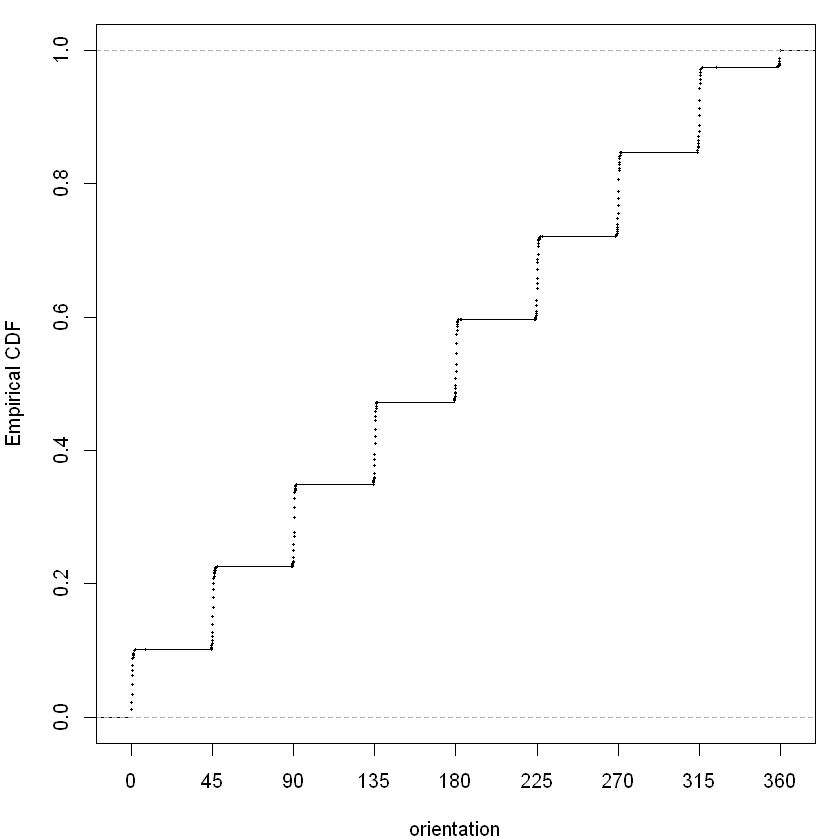

In [123]:
# Length of orientation
# Plotting the distribution of orientation
#Computing an empirical cumulative distribution function, with “ecdf” object.
print(paste("Number of Unique Orientation :",length(unique(offline$orientation))))
print("Empirical CDF of Orientation for the Hand-Held Device")

#pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar <- par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
#dev.off()


* According to the documentation, we should have only have 8 values for the orientation from 0 to 215. However, based on the result above there are 203 distinct orientation values in the data. Above figure shows the distribution of the orientations which around 8 basic orientations that 45 degree apart. Also, 0 orientations is split into 2 groups, 0 and 360.

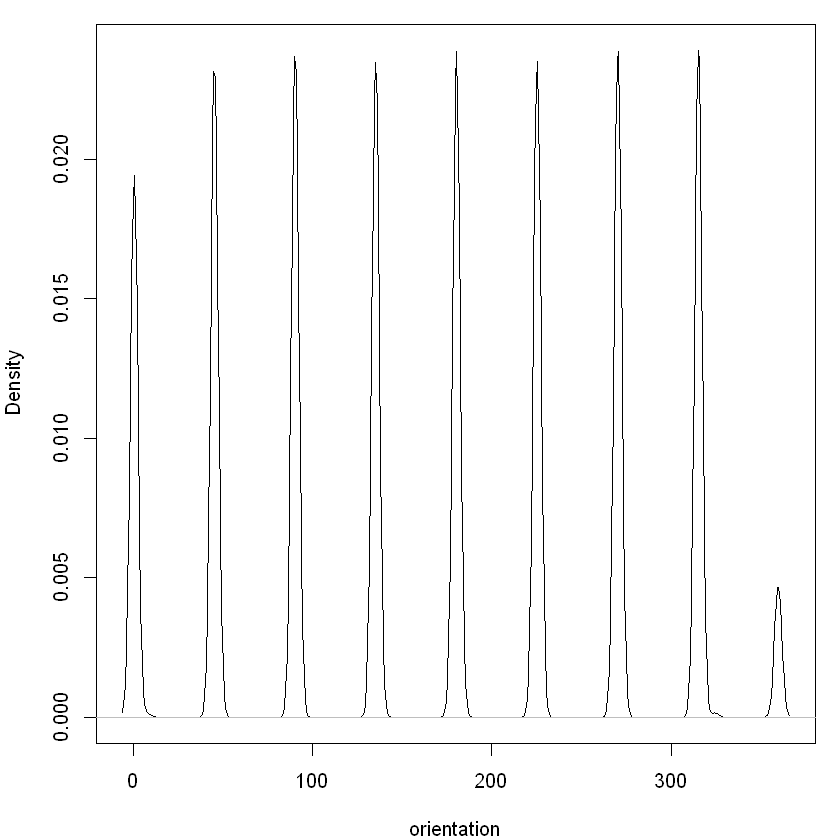

In [124]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar <- par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2), 
 xlab = "orientation", main = "")
par(oldPar)
#dev.off()

* Above density plot also approved the orientation problem with 0 orientation split into 2 groups.

In [125]:
roundOrientation <- function(angles) {
  refs <- seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

* we used the **roundOrientation** function to standarlize the orientation.

In [126]:
# round the orientation degree
offline$angle <- roundOrientation(offline$orientation)

In [127]:
head(offline)
print(paste("Number of Unique Angle :",length(unique(offline$angle))))

time,posX,posY,orientation,mac,signal,channel,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,2427000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,2422000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,1.1e+12,0


[1] "Number of Unique Angle : 8"


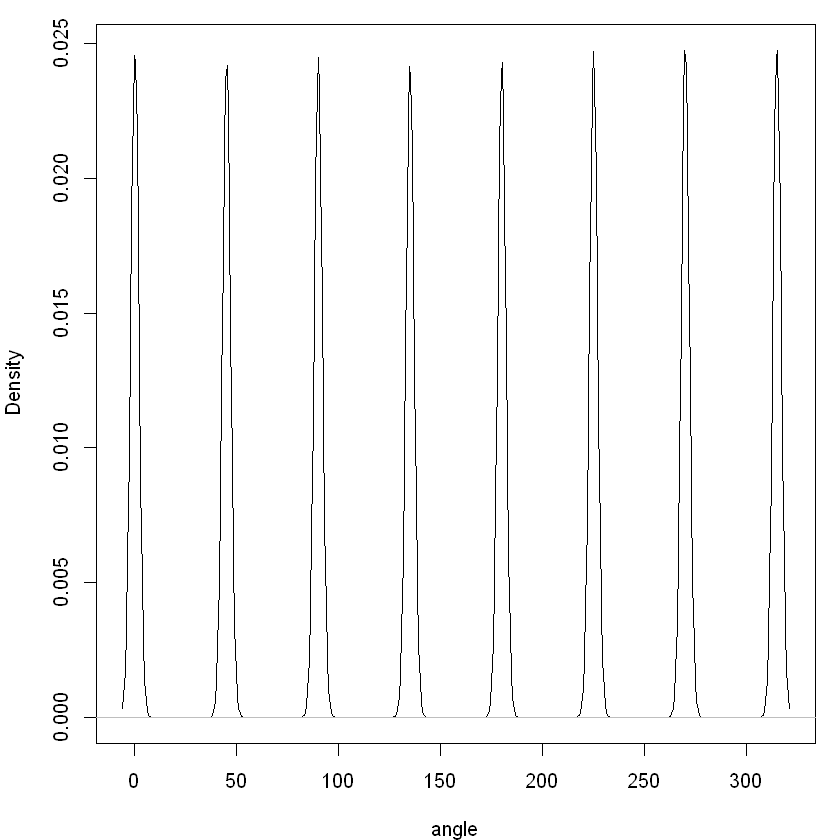

In [128]:

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar <- par(mar = c(4, 4, 1, 1))
plot(density(offline$angle, bw = 2), 
 xlab = "angle", main = "")
par(oldPar)
#dev.off()

* After run the round orientation function, we only see 8 angles now.

### Exploring MAC Addresses

In [129]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

table(offline$mac)

[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

* Clearly the first and last two are not near the testing area or were only working/active for a short time during the measurement process since they have lower counts.
* also the third and fifth addresses may not amoung the access points displayed on the map since they have lower counts than others.
* The rest of the MACs are true access points.

In [130]:
subMacs <- names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline <- offline[ offline$mac %in% subMacs, ]


* remove other MACs and only keep MACs from location 1-7.

In [131]:
head(offline)

time,posX,posY,orientation,mac,signal,channel,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,2427000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,2422000000,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,1.1e+12,0


In [132]:
# list the channel for each MAC
macChannel <- with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

* This means MAC and channel is one to one relationship. Then we can eliminate **channel** from **offline** data frame.

In [133]:
offline <- offline[ , "channel" != names(offline)]
head(offline)

time,posX,posY,orientation,mac,signal,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.1e+12,0


### Position of the Hand-Held Device

* In **offline** data frame we see posX and postY fields, we can allocate the hand-device by (x,y). We can get the location and plot them together then we can see the signles in each location.

In [134]:

#
locDF <- with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)


[1] 476

In [135]:
# number of null 
sum(sapply(locDF, is.null))
# remove Null
locDF <- locDF[ !sapply(locDF, is.null) ]

length(locDF)

[1] 310

[1] 166

* There are 476 locations in the data frame, 310 of them are null and only 166 of them has the valid location.

In [136]:
locCounts <- sapply(locDF, nrow)

locCounts <- sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)

dim(locCounts)

locCounts[ , 1:8]

[1] "matrix"

[1]   3 166

posX,0,1,2,0,1,2,0,1
posY,0,0,0,1,1,1,2,2
count,5505,5505,5506,5524,5543,5558,5503,5564


* Get the counts for each location.

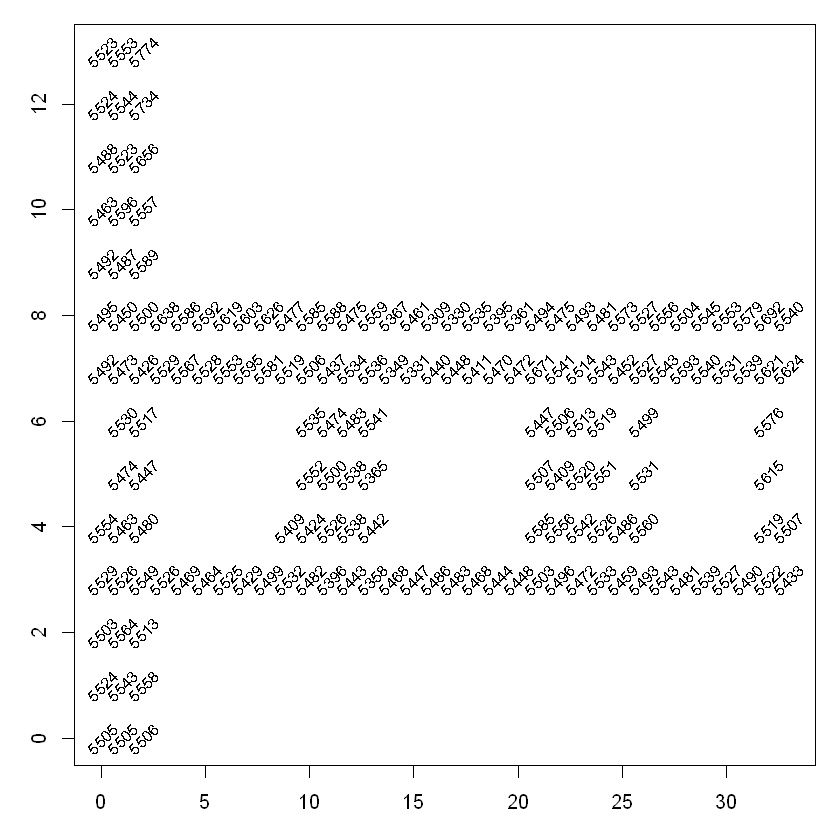

In [137]:
#pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar <- par(mar = c(3.1, 3.1, 1, 1))

locCounts <- t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "" )
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
#dev.off()

* From aobe plot, we see that there are roughly 5,500 records (8 Orientations x 110 replications x 7accesspoints) at each position. It is roughly the same number of signals detected at each location.

### Create readData Function

In [138]:
       
# read data
readData <- 
  function(filename = 'Data/offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt <- readLines(filename)
    lines <- txt[ substr(txt, 1, 1) != "#" ]
    tmp <- lapply(lines, processLine)
    offline <- as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) <- c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline <- offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars <- c("scanMac", "posZ", "channel", "type")
    offline <- offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline <- offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars <- c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime <- offline$time
    offline$time <- offline$time/1000
    class(offline$time) <- c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle <- roundOrientation(offline$orientation)
      
    return(offline)
  }




In [139]:
# call function to read the data from file

offlineRedo <- readData()

In [140]:
identical(offline, offlineRedo)

[1] TRUE

* This confirmed that offline populated manually is the same as the function returns. 

In [141]:

findGlobals(readData, merge = FALSE)$variables

[1] "as.numeric"  "processLine"

In [142]:
head(offline)

time,posX,posY,orientation,mac,signal,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.1e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.1e+12,0


### Singnal Strength Analysis

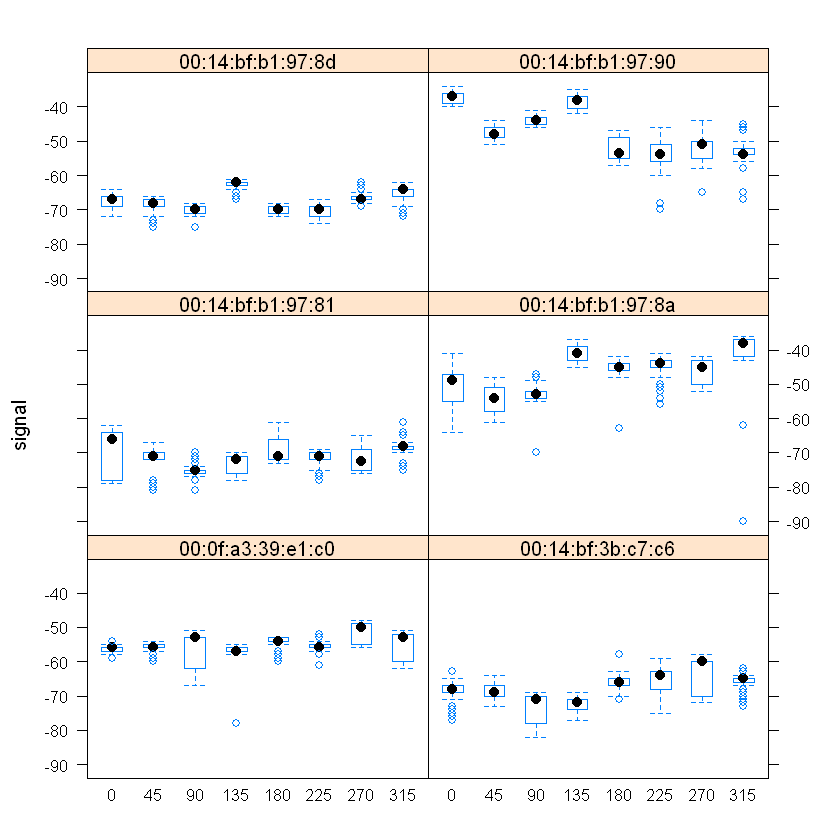

In [143]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar <- par(mar = c(3.1, 3, 1, 1))

bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
#dev.off()



* Above plot demostrates the distribution of signal strength at different orientations for different access points. The signal strength varies with the orientation for both close and distant access points.

In [144]:
# distribution of the signal strength
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

* Signal strength is measured as negative value.

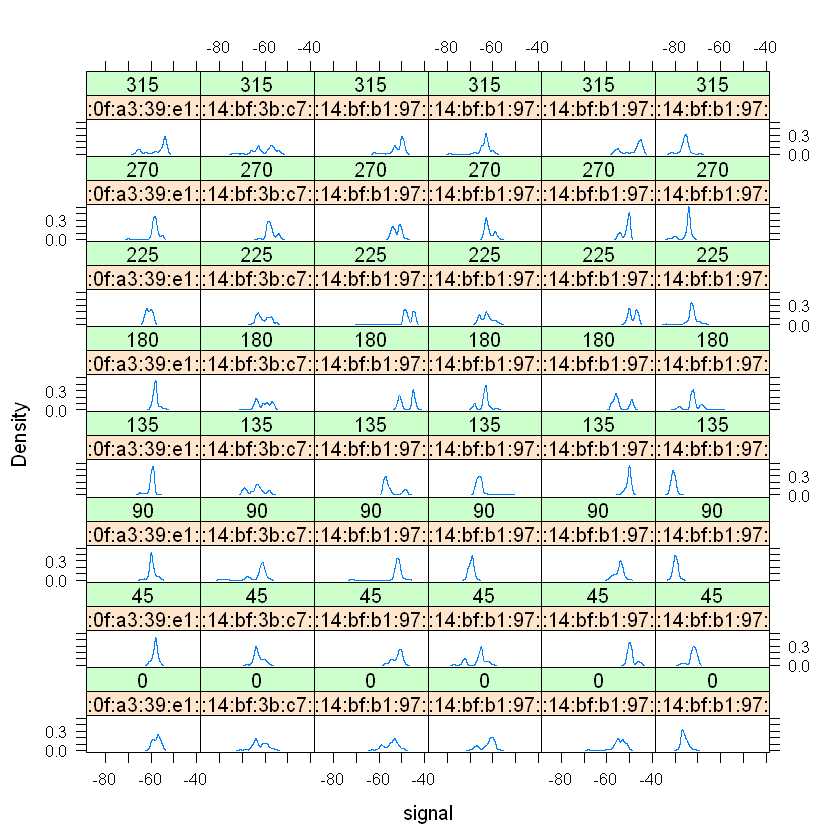

In [145]:
# plot for the signal strength distribution in each angel

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar <- par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
#dev.off()

* According to above plot, many of these distributions looks normal. However some of them have secondary modes and skewness. And, the center of the distribution varies with angle and MAC address. This tell us that the condidtiong on angle and MAC address is warranted. Please note MAC 00:0f:a3:39:dd:cd has been remove as it is extra address.

In [146]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY <- paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP <- with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary <- 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary <- do.call("rbind", signalSummary) 

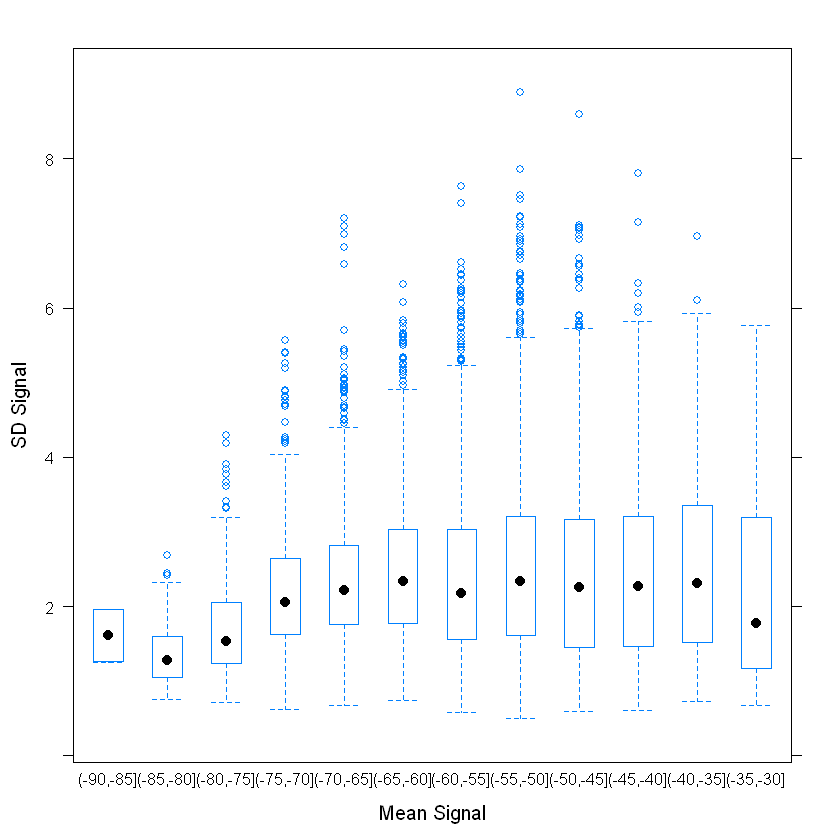

In [147]:

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar <- par(mar = c(3.1, 3, 1, 1))

breaks <- seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
#dev.off()

* The mean of the signal increases then the SD of the signal increase as well. The weak signals have low variability and the stronger signals have greater variablity.

### The Relationship between Signal and Distance

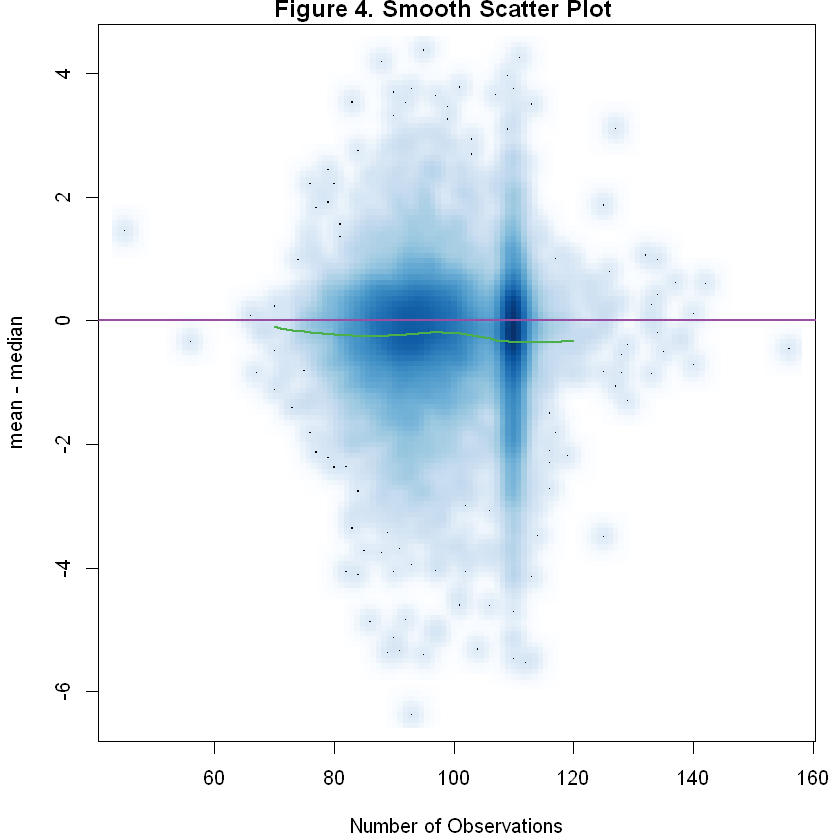

In [148]:
    
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar <- par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"
                  )
    )
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj <- with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
title("Figure 4. Smooth Scatter Plot", adj = 0.5, line = 3.4)

#dev.off()




* Heat map shows the difference between the mean and median signal strength for each combination of location, access point, and angle against the number of observations.
* The differences are close 0 to 2 dBm.

In [149]:
# surfaceSS function to find the relationship of the MAC and angle relationship
surfaceSS <- function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle <- data[ data$mac == mac & data$angle == angle, ]
  smoothSS <- Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth <- predictSurface(smoothSS)
  title <- paste("MAC: ", mac,' Angle: ', angle)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n"
              ,main = title,cex.main=0.2
              )
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

In [150]:
subMacs

[1] "00:0f:a3:39:e1:c0" "00:0f:a3:39:dd:cd" "00:14:bf:b1:97:8a"
[4] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:90" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:81"

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

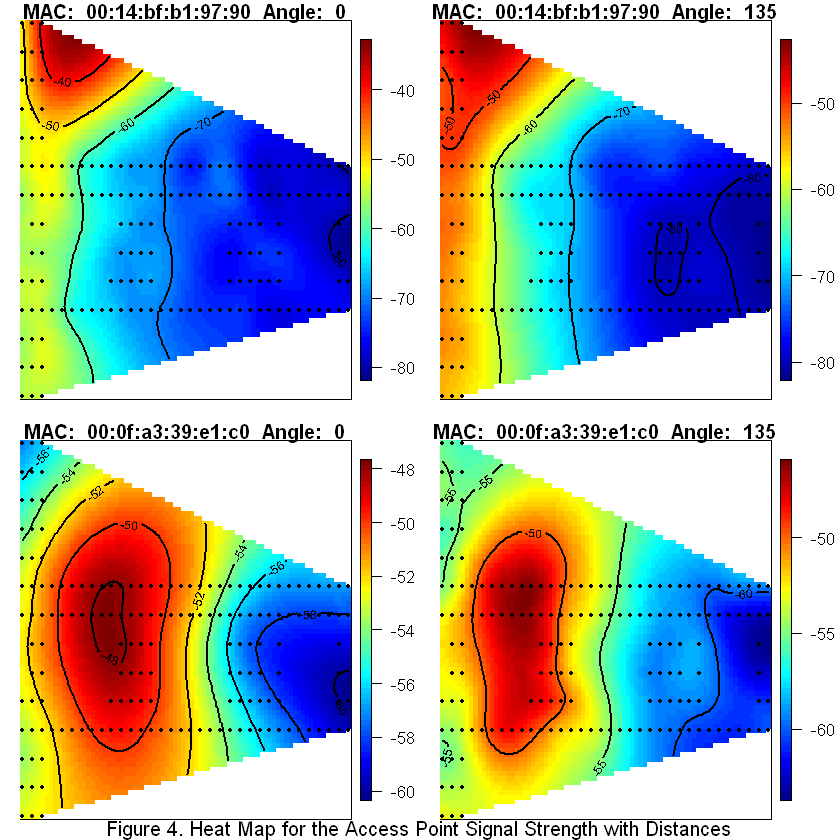

In [151]:
# 2 x 2 plot
parCur <- par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary)
      
      )
 
par(parCur)
mtext("Figure 4. Heat Map for the Access Point Signal Strength with Distances", side = 3, line = -35, outer = TRUE)
#text(-0.5,-0.5,"Figure 4. Heat Map for the Access Point Signal Strength with Distances",cex=3,font=8)

* The topographic heat map shows the signal strength in two angels(0,135) for MAC 00:14:bf:b1:97:90 and 00:0f:a3:39:e1:c0. You can clearly see the location of the access point which is in the dark red area in the heat map.

In [152]:
# exclude 00:0f:a3:39:dd:cd
offlineSummary <- subset(offlineSummary, mac != subMacs[2])
# remove it in offline data frame as well
offline <- offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

* MAC  00:0f:a3:39:dd:cd is removed

In [153]:

# get the location of the access point.

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP


,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


* The above matrix is created based on the topographical heat map for each access point on the top of the floor plan. We decided the first access point 00:0f:a3:39:e1:c0 first (x=7.5, y=6.3) and according to the documentation the training data were mearusred at 1 meter intervals in the building. So we can use the grey dots on the plan to estimate the location of the access points. 

In [154]:
# difference from each training point to each access point.
diffs <- offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist <- sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)


* We add a **dist** column to calculate the distance from each training point to the access point. The distance may have inversely proportional relationship with the signal strength.

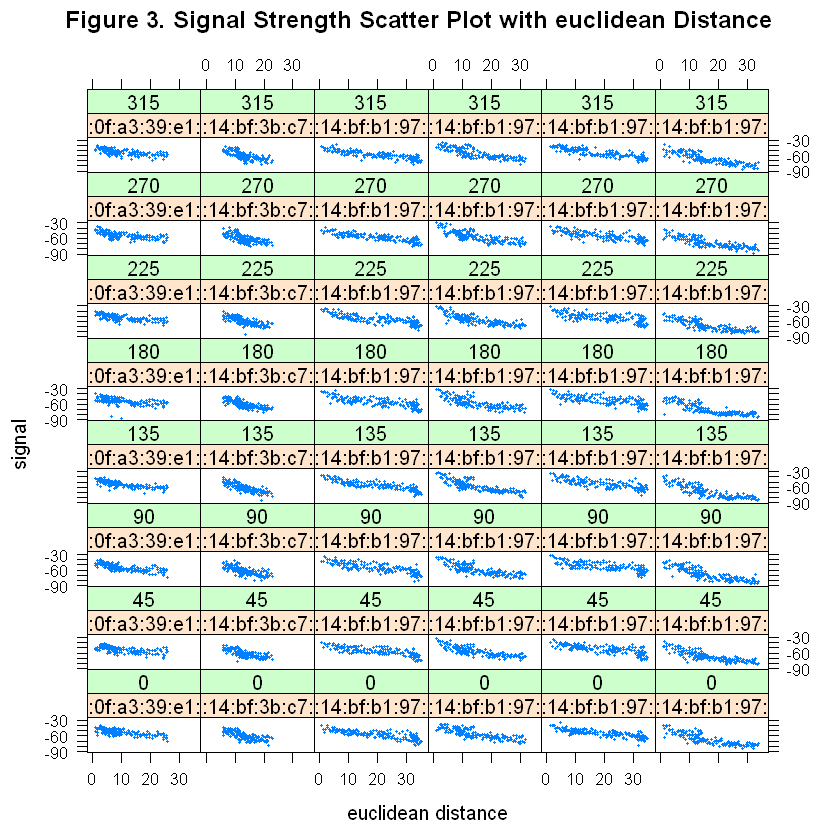

In [155]:

# Plot the relationship between the distance and the signal strength.
oldPar = par(mar = c(3.1, 3.1, 1, 1))
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="euclidean distance",
       main = "Figure 3. Signal Strength Scatter Plot with euclidean Distance")
par(oldPar)


* These 48 scatter plot shows the relationship between the signal strength and the distance to the access point for each of the 6 access points and 8 orientations ofthe device. This is confirmed our assumption that the farther of the distance the weaker signal will have.

#### Try Manattan dist

In [156]:
offlineSummary$manhattan_dist <- abs(diffs[ , 1] + diffs[ , 2])

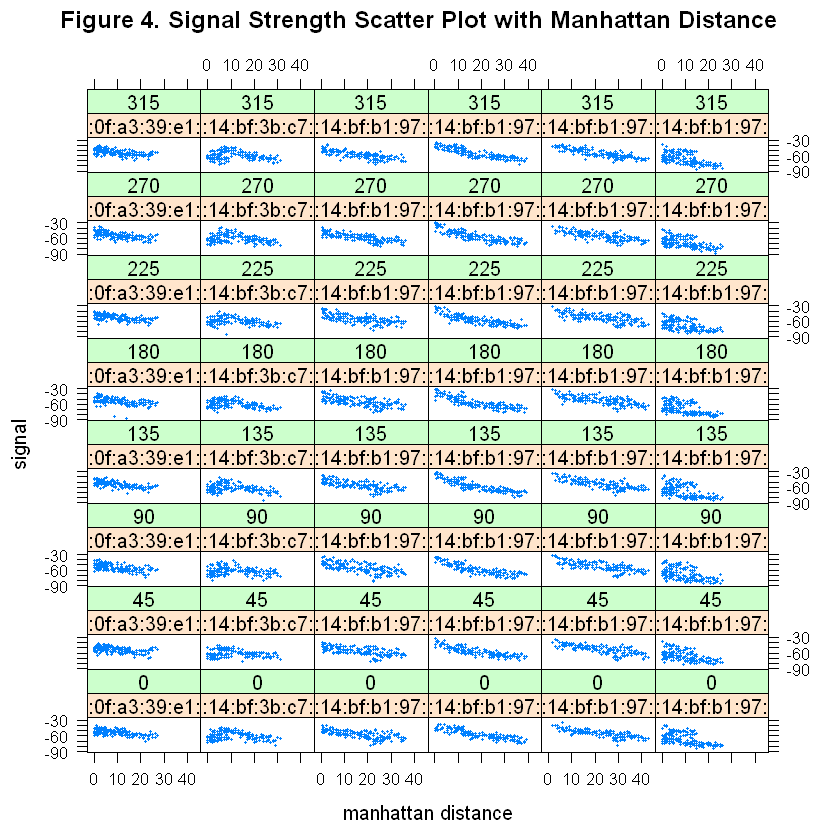

In [157]:
# Plot the relationship between the distance and the signal strength.
oldPar = par(mar = c(3.1, 3.1, 1, 1))

xyplot(signal ~ manhattan_dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="manhattan distance",
       main = "Figure 4. Signal Strength Scatter Plot with Manhattan Distance"
      )
par(oldPar)

* 

## Build Model to Predict Location

### Prepare the Test Data

In [158]:
macs <- unique(offlineSummary$mac)
online <- readData("Data/online.final.trace.txt", subMacs = macs)
# create unique identifier for location
online$posXY <- paste(online$posX, online$posY, sep = "-")
# unique number of locations
length(unique(online$posXY))

tabonlineXYA <- table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars <- c("posXY", "posX","posY", "orientation", "angle")
byLoc <- with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))
# confirm the data set
onlineSummary <- do.call("rbind", byLoc)  

dim(onlineSummary)
names(onlineSummary)

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

[1] 60 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

* Import and organize the test data

### Choice of Orientation

* pick up the nearest angle for each test point.

In [159]:

# function to aggregate the signal strengths from the angels and create a data structure.
reshapeSS <- function(data, varSignal = "signal", 
                      keepVars = c("posXY", "posX","posY")) {
  byLocation <- with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS <- do.call("rbind", byLocation)
  return(newDataSS)
}


In [160]:
# function to get the average of the signal strengths for the different angles 
# to produce one set of signal strengths for each of the 166 locations in the training data
selectTrain <- function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs <- seq(0, by = 45, length  = 8)
  nearestAngle <- roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles <- seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m <- m + 1
    angles <- seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles <- angles[ -1 ]
    else 
      angles <- angles[ -m ]
  }
  angles <- angles + nearestAngle
  angles[angles < 0] <- angles[ angles < 0 ] + 360
  angles[angles > 360] <- angles[ angles > 360 ] - 360
  angles <- sort(angles) 
  
  offlineSubset <- signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [161]:


train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])


,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52,-66,-63,-36,-64,-55
0-1,0-1,0,1,-53,-65,-64,-39,-65,-59
0-10,0-10,0,10,-56,-66,-69,-45,-67,-50
0-11,0-11,0,11,-55,-67,-70,-48,-67,-55
0-12,0-12,0,12,-56,-70,-72,-45,-67,-50
0-13,0-13,0,13,-55,-71,-73,-43,-69,-54


[1] 166

* This approach is use the selecTrain fuction to find the nearest access point base on the signal strengths.

### Find the Nearest Neighbors

In [162]:
# function to calculate the distance from the test data to all of the training data and get the top 3 nearest.
findNN <- function(newSignal, trainSubset) {
  diffs <- apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists <- apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest <- order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [163]:
# function for predicting the location X, Y
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [164]:
# call predXY function to predict the location for K =3
estXYk3 <- predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# call predXY function to predict the location for K =1
estXYk1 <- predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

In [165]:
# floor error map function 
floorErrorMap <- function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

In [166]:
trainPoints <- offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

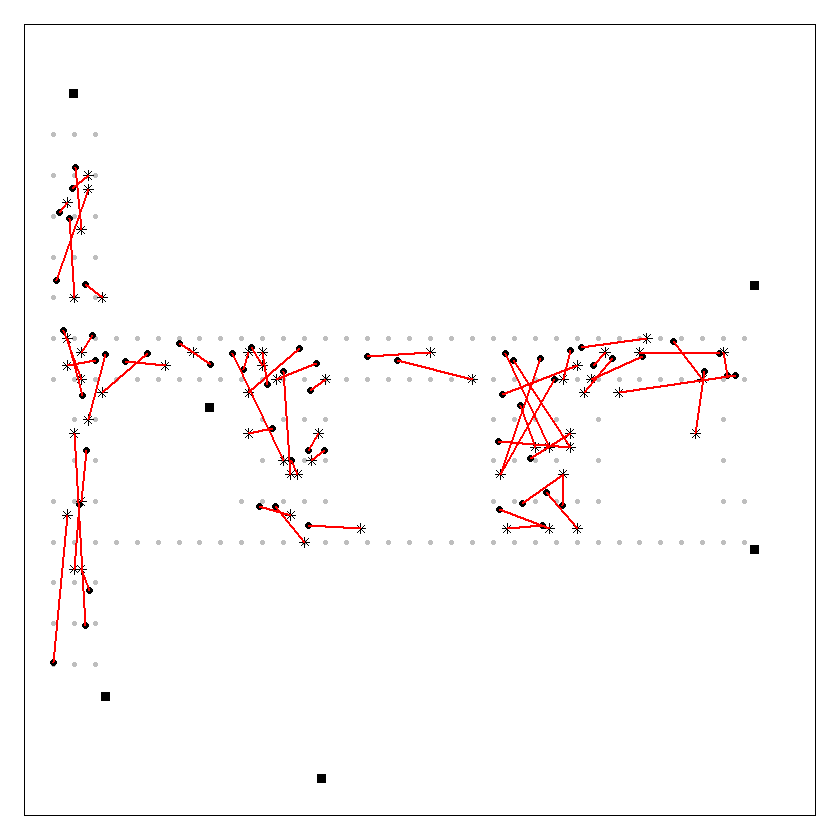

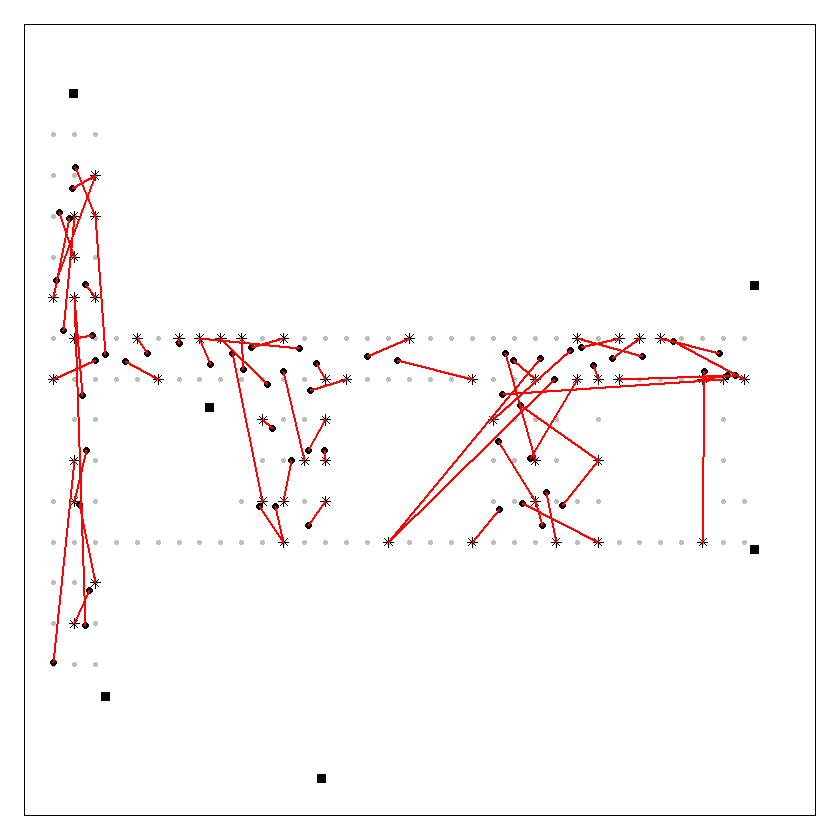

In [167]:
# draw error map for K=3
oldPar <- par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)

# draw error map for K=1
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)



* Above are the floor plan for predicted and actual locations. The red connects the test locations(black dot) with their predicted locations ( asterisks). top one is for K=3 and bottome one is for k = 3 nearest neighbors. 

In [168]:
# error function to measure the errors between the estimate location and actual location.
calcError <- function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

In [169]:
actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)


v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])


[1] 659 307

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

In [170]:
# new reshapSS function
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [171]:


keepVars <- c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary <- reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold <- subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold <- subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold <- predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold <- onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 60

In [172]:
tic("sleeping")
K <- 20
err <- rep(0, K)

for (j in 1:v) {
  onlineFold <- subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold <- subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold <- onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold <- predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] <- err[k] + calcError(estFold, actualFold)
  }
}
toc()

sleeping: 315.26 sec elapsed


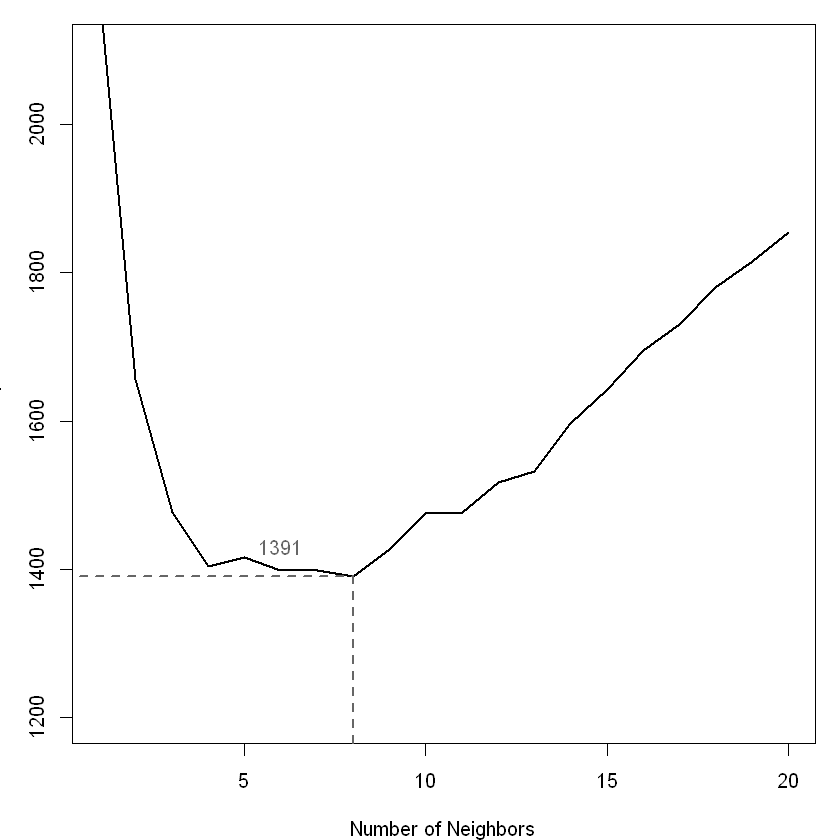

In [173]:

#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
oldPar <- par(mar = c(4, 3, 1, 1))
plot(y <- err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin <- min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
par(oldPar)
#dev.off()

In [174]:
# look like k = 5 is good
estXYk5 <- predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

knnResults = calcError(estXYk5, actualXY)

### Use Manhattan Distance

In [175]:

# function to calculate the distance from the test data to all of the training data and get the top 3 nearest.
findNNManhattan <- function(newSignal, trainSubset) {
  diffs <- apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  # print(diffs)
  dists <- apply(diffs, 2, function(x) sum(abs(diffs)) )
  closest <- order(dists)
  return(trainSubset[closest, 1:3 ])
}


In [176]:
# function for predicting the location X, Y
predXYManhattan <- function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY <- list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS <- selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] <-findNNManhattan(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY <- lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY <- do.call("rbind", estXY)
  return(estXY)
}

In [177]:

estXYk5Manhattan <- predXYManhattan(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

knnManhattanResults = calcError(estXYk5Manhattan, actualXY)


### Alternative Solution

In [178]:
# function to calculate the distance from the test data to all of the training data and get the top 3 nearest.
findNNWeighted <- function(newSignal, trainSubset) {
  diffs <- apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists <- apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest <- order(dists)
  weight = as.numeric(1/dists[closest])
  closeXY =trainSubset[closest, 1:3 ]
  return(cbind(closeXY,weight))
}


In [179]:
# function to get the estimate location 
predXYWeighted <- function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY <- list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS <- selectTrain(newAngles[i], trainData, m = numAngles)
    base <- findNNWeighted(newSignal = as.numeric(newSignals[i, ]), trainSS)
    weights <- append(base[1:k, 4]/sum(base[1:k, 4]), rep(0, nrow(base)-k)) 
    base[, 2:3] = base[, 2:3]*weights # multiply weights array * matrix of x,y to get weighted vals
    closeXY[[i]] = base[,1:3] # append weighted xy, x, y values to list
  }

  estXY <- lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) sum(x)))
  estXY <- do.call("rbind", estXY)
  return(estXY)
}

In [184]:

estXYk5Weighted <- predXYWeighted(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

knnWeightedResults = calcError(estXYk5Weighted, actualXY)


In [185]:
# Regular knn error
print(paste("Regular KNN error: ",knnResults))
# Regular knn using Manhattan Distance error
print(paste("Regular KNN using Manhattan Distance error: ",knnManhattanResults))
# weighted knn error
print(paste("Weighted KNN error:",knnWeightedResults))

[1] "Regular KNN error:  275.5083"
[1] "Regular KNN using Manhattan Distance error:  17790.1683"
[1] "Weighted KNN error: 273.121241611466"


### Conclusions

### References